# Euler and RK 4

Reusable class to calculate approximations using forward euler and rk4. SDC inherits.

In [2]:
import numpy as np

class SchemesPy: 
    soln = []
    
    def __init__(self, v_field, start, stop, h, init_conditions):
        self.vector_field = v_field
        self.ics = init_conditions
        self.a = start
        self.b = stop
        self.times = np.arange(self.a,self.b,h)  
        self.h = h
          
    def prep_preds(scheme):
        def wrapper(self):
            n = self.vector_field(self.ics, 
                                  self.times[0]).size
            x = np.zeros(((self.times).size,
                          n))
            x[0,:] = self.ics
            self.soln = scheme(self,x).flatten()
            return self.times, self.soln
        return wrapper
 
    @prep_preds
    def euler(self, x):
        for k, t in enumerate(self.times[:-1]):
            x[k+1,:] = x[k,:]+self.h*self.vector_field(x[k,:],t)
        return x
    
    @prep_preds
    def rk4(self, x):
        for k, t in enumerate(self.times[:-1]):
            f1 = self.vector_field(x[k,:],t)
            f2 = self.vector_field(x[k,:]+0.5*self.h*f1,t+0.5*self.h)
            f3 = self.vector_field(x[k,:]+0.5*self.h*f2,t+0.5*self.h)
            f4 = self.vector_field(x[k,:]+self.h*f3,t+self.h)
            x[k+1,:] = x[k,:]+self.h/6*(f1+2*f2+2*f3+f4)
        return x
    
    def __str__(self):
        return np.dstack((self.times, self.soln))
        

In [ ]:
dy_dt = lambda y,t : 1 - t + 4*y
y_pred = SchemesPy(v_field=dy_dt, 
                   start=0, 
                   stop=2, 
                   h=0.01, 
                   init_conditions=1)

# Algorithm 4.1 (Spectral Deferred Correction).

###  Compute initial approximation
For non-stiff/stiff problems, use the forward/backward Euler method to compute an approximate solution φ_i ≈ φ(s_i ) at the nodes s1, ..., sm on the interval [a,b].

The jth approximate solution is psi[j].
###  Compute successive corrections.
    do j = 1,...,J
        1) Compute the approximate residual function 
            σ(φ[j−1]).
        2a) For non-stiff problems, compute 
            δ[j] = C_exp(G,σ(φ[j−1]))
        2b) For stiff problems, compute 
            δ[j] = C_imp(G, σ(φ[j−1]))
        3) Update the approximate solution 
            φ[j] = φ[j−1] + δ[j].
    enddo

In [ ]:
class LagrangePoly:

    def __init__(self, X, Y):
        self.n = len(X)
        self.X = np.array(X)
        self.Y = np.array(Y)

    def basis(self, x, j):
        b = [(x - self.X[m]) / (self.X[j] - self.X[m])
             for m in range(self.n) if m != j]
        return np.prod(b, axis=0) * self.Y[j]

    def interpolate(self, x):
        b = [self.basis(x, j) for j in range(self.n)]
        return np.sum(b, axis=0)

In [3]:
from scipy.integrate import quadrature 

class SchemeEXT(SchemesPy):
    
    """ For non-stiff problems which are numerically stable. 
    Stiff problems are when certain numerical methods for solving 
        the equation are numerically unstable, unless the step size is 
        taken to be extremely small.
    """

    def c_exp(self, G, residuals, m):
        delta = np.zeros(m)
        for i in range(0,m-1):
            h_i = self.gl_nodes[i+1] - self.gl_nodes[i]
            delta[i+1] = delta[i] + h_i*G(i, delta[i]) + residuals[i+1] - residuals[i]
        return delta


    def sdc(self):
        # Initial approximation
        ts, f_euler = self.euler()
        m=len(f_euler)


        # Each row an approximation with there being J approximations
        J= 10
        self.psi = np.zeros((J,m))
        self.psi[0]= f_euler        
        
        # Gauss Legenre nodes, s1 .. sm on [a,b]
        # Poynomial degree m with points at sample_point and with weights
        self.gl_nodes, polynomial = np.polynomial.legendre.leggauss(m)
        self.gl_nodes = (self.b - self.a)/2 *self.gl_nodes + (self.b+self.a)/2 
        
        # For the corrections
        G = lambda i, res : self.vector_field(self.psi[0][i] + res,ts[i]) - self.vector_field(self.psi[0][i],ts[i])

        # J Successive corrections
        for j in range(1, 4):            
            # Residual = S^m _F(psi[j-1])- psi(j-1) + ^psi_a
            _F = [self.vector_field(self.psi[j-1][i] , self.gl_nodes[i]) for i in range(m)]

            _psi_a = [self.psi[j-1][0]]*m
            
            S_mF = [quadrature(self.vector_field, -1, ts[i], (_F[i]))[0] for i in range(m)]
            
            residual = S_mF- self.psi[j-1] + _psi_a

            # For non-stiff problems (C_exp), the correction
            delta = self.c_exp(G, residual,m)

            # Update approximate solution
            self.psi[j]= self.psi[j-1] + delta

        return self.psi[-1]

In [ ]:
dy_dt = lambda y,t : 1 - t + 4*y
dy2_dt = lambda y,t : 4*t*np.sqrt(y)

y = SchemeEXT(v_field=dy_dt, 
        start=0, 
        stop=2, 
        h=0.01, 
        init_conditions=1).sdc()
y

# Order of Convergence
TEST: y'=4tsqrt(y)    
SOLN: y=y0*(1+t^2)^2 with (ICS) y0=1 

change timesteps

In [9]:
from pandas import DataFrame as DF
from matplotlib import pyplot as plt

def plot_df(df, h):
    fig, [[ax1, ax2], [ax3,ax4]]= plt.subplots(nrows=2, ncols=2, figsize=(15,10))
    df.plot(title='Exact vs Euler vs RK4 vs SDC with h='+str(h), 
            x='times', 
            y=['euler','rk4','sdc', 'exact'],
            ax=ax1)
    df.plot(title='Error of Euler vs time with h='+str(h), 
            x='times', 
            y='error_euler',
            ax=ax2)
    df.plot(title='Error of RK4 vs time with h='+str(h), 
            x='times', 
            y= 'error_rk4',
           ax=ax3)
    df.plot(title='Error of SDC vs time with h='+str(h), 
            x='times', 
            y= 'error_sdc',
           ax=ax4)

def analyse_scheme(dy_t, y, ics, step_sizes):
        max_global_error = []
        for h in step_sizes:
                y_pred = SchemeEXT(v_field=dy_dt, 
                                start=0, 
                                stop=5, 
                                h=h, 
                                init_conditions=y0)

                times = y_pred.euler()[0]
                exact =[y(t) for t in times]

                df = DF({'times': times,
                        'euler' : y_pred.euler()[1],
                        'rk4' :  y_pred.rk4()[1],
                        'sdc' : y_pred.sdc(),
                        'exact': exact })

                df['error_euler'] = df['exact'].sub(df['euler']).abs()
                df['error_rk4'] = df['exact'].sub(df['rk4']).abs()
                df['error_sdc'] = df['exact'].sub(df['sdc']).abs()
                max_global_error.append([df['error_euler'].max(),
                                                df['error_rk4'].max(), 
                                                df['error_sdc'].max()])
                plot_df(df,h)
        return max_global_error

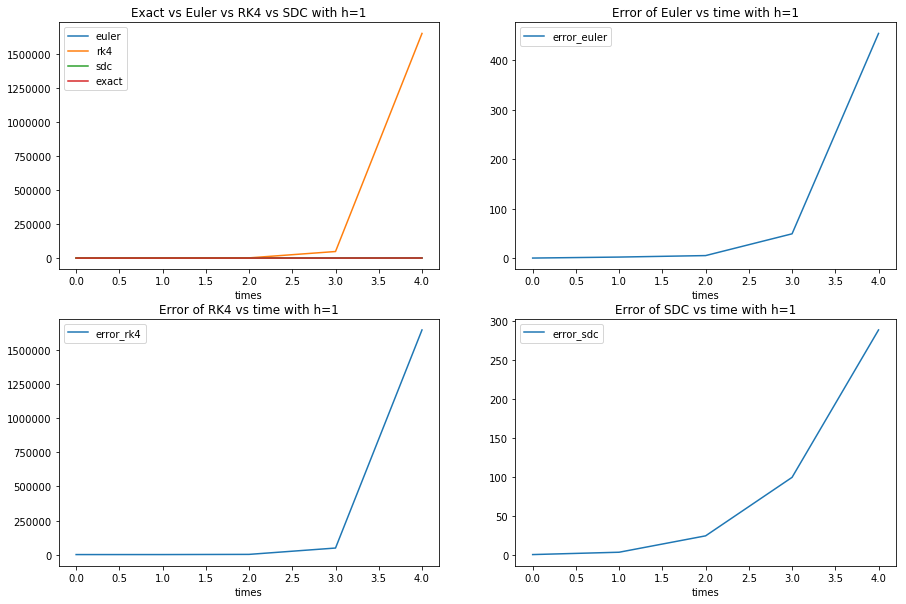

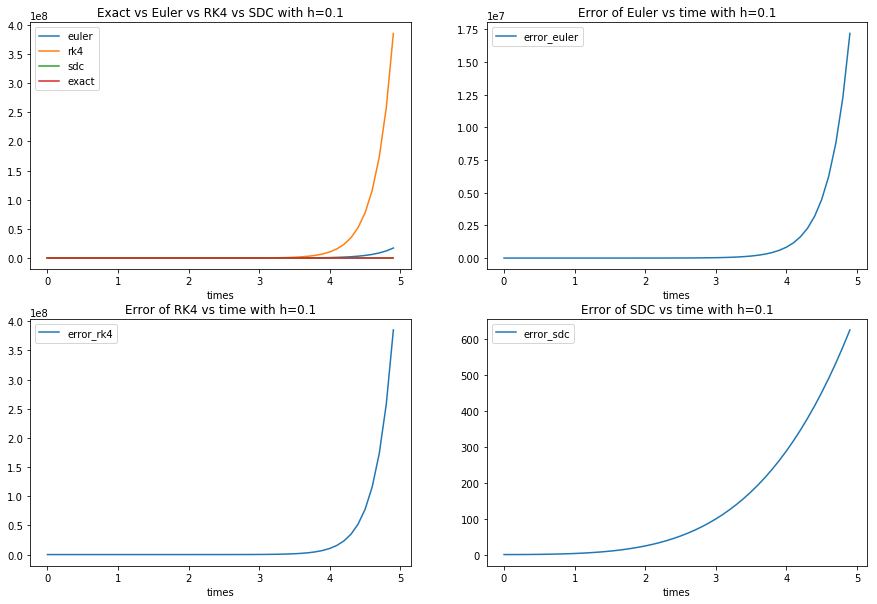

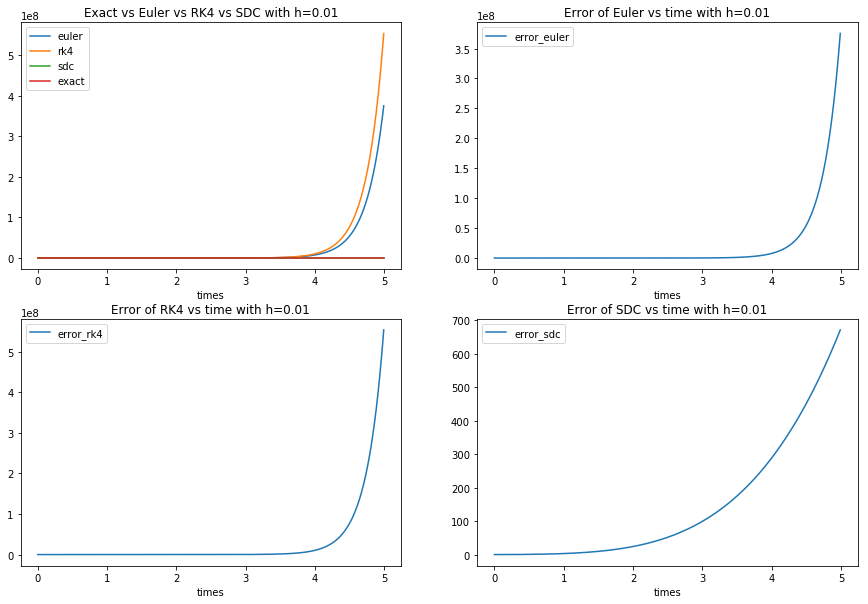

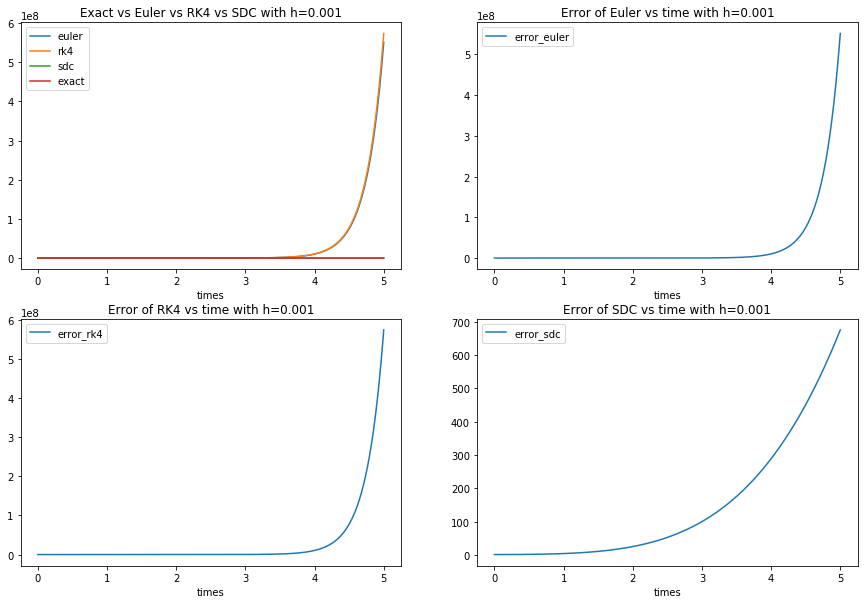

In [10]:
h_sizes = [10**i for i in range(0,-4, -0.5)]

dy_dt = lambda y,t : 1 - t + 4*y
y = lambda t: (19/16)*np.e**(4*t) + t/4 -3/16

dy2_dt = lambda y,t : 4*t*np.sqrt(y)
y2 = lambda t: y0*(1+t**2)**2

y0=1

max_global_err = analyse_scheme(dy2_dt, y2, y0, h_sizes)

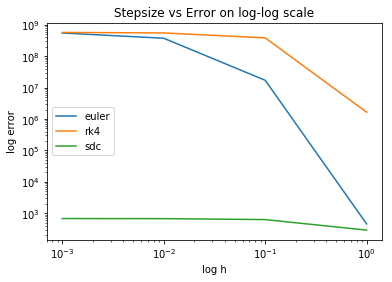

In [11]:
plt.plot(h_sizes,max_global_err)
plt.yscale('log')
plt.xscale('log')
plt.ylabel('log error')
plt.xlabel('log h')
plt.legend(['euler', 'rk4', 'sdc'])
plt.title('Stepsize vs Error on log-log scale')
plt.show()